In [34]:
import tensorflow as tf
from tensorflow.keras.applications import vgg19
import os
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import backend as k
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img,save_img,img_to_array

%matplotlib inline

# Image preprocessing and Visualisation

In [35]:
cur_dir = os.getcwd()

In [77]:
#generating path for the content image and the stylistci image
style_path = cur_dir + "\\resized\\resized\\Pieter_Bruegel_60.jpg"
style_img = load_img(style_path,target_size = (224,224,3))
content_path = cur_dir + "\\landscape.jpeg"
content_img = load_img(content_path,target_size = (224,224,3))

ERROR! Session/line number was not unique in database. History logging moved to new session 231


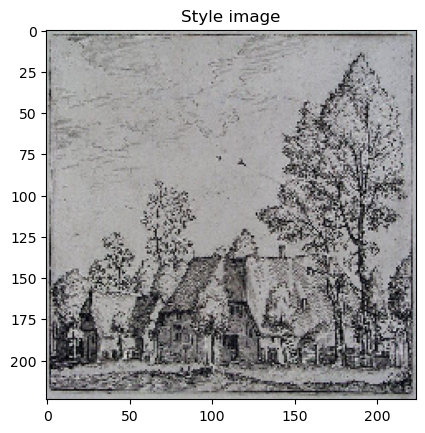

In [78]:
plt.imshow(style_img)
plt.title('Style image')
plt.show()

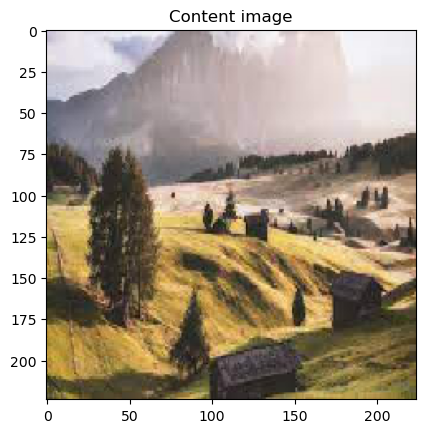

In [79]:
plt.imshow(content_img)
plt.title('Content image')
plt.show()

In [80]:
img_rows = 224
img_cols = 224

In [81]:
#preprocessing the image to fit the vgg19 model
def preprocess_input(img_path):
    img  = load_img(img_path,target_size = (img_rows,img_cols))
    img =  img_to_array(img)
    img = np.expand_dims(img,axis = 0)
    img = vgg19.preprocess_input(img)
    return img

In [82]:
#converting images to Keras tensors
input_style_img  = k.variable(preprocess_input(style_path))
input_content_img = k.variable(preprocess_input(content_path))

In [83]:
input_style_img.shape

TensorShape([Dimension(1), Dimension(224), Dimension(224), Dimension(3)])

In [84]:
# assining random image to the target image
if k.image_data_format == 'channels_first':
    combination_img = k.placeholder((1,3,img_rows,img_cols))
else :
    combination_img = k.placeholder((1,img_rows,img_cols,3))

In [85]:
input_tensor = k.concatenate([input_style_img,input_content_img,combination_img],axis =0)

In [86]:
input_tensor.shape

TensorShape([Dimension(3), Dimension(224), Dimension(224), Dimension(3)])

# Building a VGG19 model for feature extraction

In [87]:
from tensorflow.keras.applications.vgg19 import VGG19

In [88]:
#pretrained model(on imagent dataset) is loaded


model = VGG19(input_tensor = input_tensor,include_top = False,weights='imagenet')

In [89]:
#printing names all the convolution layers


for layer in model.layers:
    if not 'conv' in layer.name:
        continue
    print(layer.output.shape)

(3, 224, 224, 64)
(3, 224, 224, 64)
(3, 112, 112, 128)
(3, 112, 112, 128)
(3, 56, 56, 256)
(3, 56, 56, 256)
(3, 56, 56, 256)
(3, 56, 56, 256)
(3, 28, 28, 512)
(3, 28, 28, 512)
(3, 28, 28, 512)
(3, 28, 28, 512)
(3, 14, 14, 512)
(3, 14, 14, 512)
(3, 14, 14, 512)
(3, 14, 14, 512)


In [90]:
#defining the layers from which feature maps would be evaluated and the layer from which content features would be evaluated


style_layer = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
content_layer = ['block5_conv2']

In [91]:
#storing feature maps in a dictionary

out_dict  = dict([(layer.name,layer.output) for layer in model.layers])

# Calculating Overall Loss

In [92]:
#buildig gram matrix to evaluate style loss

def gram_matrix(input_tensor1):
    assert k.ndim(input_tensor1) == 3
    num_of_kernel = int(input_tensor1.shape[-1])
    a = tf.reshape(input_tensor1,[-1,num_of_kernel])
    gram = tf.matmul(a, a, transpose_a=True)
    return gram

In [93]:
# Evaluation of Content Loss

def content_loss(content_tensor,combination_tensor):
    return k.mean(k.square(content_tensor-combination_tensor))

In [94]:
#Evaluation of Style Loss

def style_loss(style_tensor,combination_tensor):
    assert k.ndim(style_tensor) == 3
    assert k.ndim(combination_tensor) == 3
    style_gram = gram_matrix(style_tensor)
    combination_gram = gram_matrix(combination_tensor)
    return k.mean(k.square(style_gram - combination_gram))

In [95]:
# Calculating overall loss

loss = k.variable(0.0)

# Calculating total style loss from all the convolution layers selected prior
style_weight = 1.0
for layer in style_layer:
    layer_output = out_dict[layer]
    style_tensor = layer_output[0,:,:,:]
    combination_tensor = layer_output[2,:,:,:]
    loss = loss + (style_loss(style_tensor,combination_tensor))
    loss = (loss/len(style_layer))*style_weight

# Content loss is calculated for the last layer of the model
content_weight = 0.05
layer_output1 = out_dict['block5_conv2']
content_tensor = layer_output1[1,:,:,:]
combination_tensor = layer_output1[2,:,:,:]
loss = loss+(content_loss(content_tensor,combination_tensor) * content_weight)

In [96]:
#calculating gradient with respect to loss

grad = k.gradients(loss,combination_img)

In [97]:
output = [loss]
if isinstance(grad,(list,tuple)):
    output+=grad
else :
    output.append(grad)

# making a keras function to evaluate the loss and gradient for an input combination image
imp_tensors = k.function([combination_img],output)
imp_tensors

# Adapting the learned features to the content image

In [98]:
# defining loss and gradient function

def loss_and_grad(output_img):
    if k.image_data_format == 'channels_first' :
        output_img = output_img.reshape((1,3,img_rows,img_cols))
    else :
        output_img = output_img.reshape((1,img_rows,img_cols,3))
    outs = imp_tensors([output_img])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

In [99]:
x_opt = preprocess_input(content_path)

In [100]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = loss_and_grad(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [101]:
evaluate = Evaluator()

# Creating the model to transfer the style to the combination image

In [102]:
import scipy

In [103]:
from scipy.optimize import fmin_l_bfgs_b

In [112]:
# using L-BFGS as the optimizer

# here only 20 iterarions have used which is quite less we should atleast use 100 iterations
iterations=20
best_loss, best_img = float('inf'), None
for i in range(iterations):
    print('Start of iteration', i)
    x_opt, min_val, info= fmin_l_bfgs_b(evaluate.loss, 
                                        x_opt.flatten(), 
                                        fprime=evaluate.grads,
                                        maxfun=20,
                                        disp=True,
                                       )
    print('Current loss value:', min_val)
    if min_val < best_loss:
        best_loss = min_val
        best_img = x_opt.copy()

Start of iteration 0
Current loss value: 3978498000000.0
Start of iteration 1
Current loss value: 3612678300000.0
Start of iteration 2
Current loss value: 3361148200000.0
Start of iteration 3
Current loss value: 3155402000000.0
Start of iteration 4
Current loss value: 2990361500000.0
Start of iteration 5
Current loss value: 2862441000000.0
Start of iteration 6
Current loss value: 2735041400000.0
Start of iteration 7
Current loss value: 2627415600000.0
Start of iteration 8
Current loss value: 2531200000000.0
Start of iteration 9
Current loss value: 2435747400000.0
Start of iteration 10
Current loss value: 2362786700000.0
Start of iteration 11
Current loss value: 2295247400000.0
Start of iteration 12
Current loss value: 2232681500000.0
Start of iteration 13
Current loss value: 2173684400000.0
Start of iteration 14
Current loss value: 2124447500000.0
Start of iteration 15
Current loss value: 2048980000000.0
Start of iteration 16
Current loss value: 1987967200000.0
Start of iteration 17
Cu

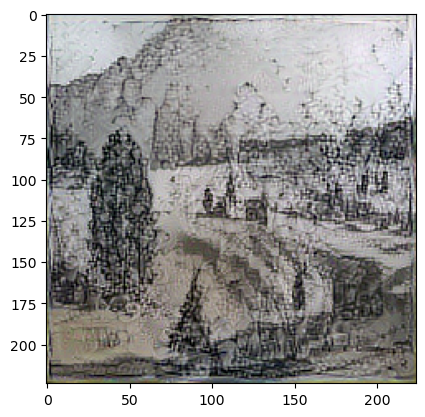

In [113]:
def deprocess_image(x):
    if k.image_data_format() == 'channels_first':
        x = x.reshape((3, img_rows, img_cols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_rows, img_cols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x
imgx = deprocess_image(best_img.copy())
plt.imshow(imgx)

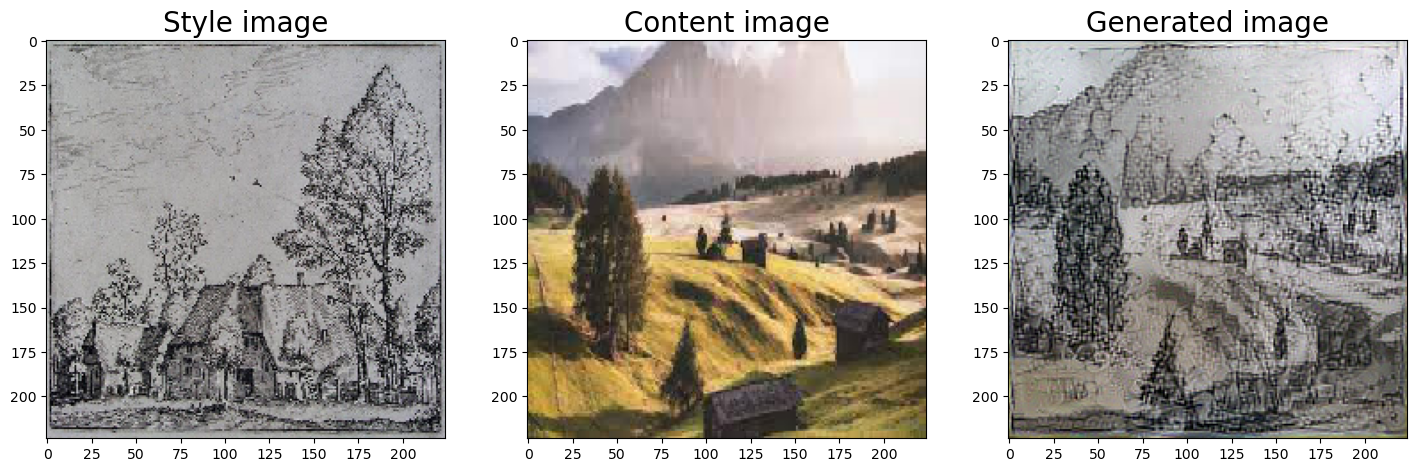

In [114]:
#plotting the style image, content image and generated image

plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Style image",fontsize=20)
plt.imshow(style_img)

plt.subplot(5,5,2)
plt.title("Content image",fontsize=20)
plt.imshow(content_img)

plt.subplot(5,5,3)
plt.title("Generated image",fontsize=20)
plt.imshow(imgx)



# Calculating Content preservation using Structure similiraty index

In [107]:
from skimage.metrics import structural_similarity as ssim
from skimage import io
from skimage import color

In [108]:
content_img_t = img_to_array(content_img) 

In [109]:
content_img_t.shape

(224, 224, 3)

In [110]:
img_gt_gray = color.rgb2gray(content_img_t)
img_generated_gray = color.rgb2gray(imgx)


In [111]:
ssi_value, _ = ssim(img_gt_gray, img_generated_gray, full=True)

print(f"Structural Similarity Index: {ssi_value}")

Structural Similarity Index: 8.561726718859395e-05


C:\Users\rakhi\anaconda3\envs\test\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


# Limitation and improvement

The above mentioned model is run only for 20 iterations hence the accuracy of the generated image not too high the accuaracy could be increased using more iterations nearly 300 or more. The vgg19 model used here is utilizing the weights of imagenet dataset the model could be improved using more stylistic images to train it. The optimizer used here is L-bfgs we could use any other optimizer which could preserve edges more efficiently.